# U.S. Treasury Yield Curve Forecasting using plain LSTM


In [22]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pandas_datareader import data as pdr
import datetime
from matplotlib import pyplot as plt

## Import data

In [23]:
# Define the start and end date of the data range
start = datetime.datetime(2005, 1, 1)
end = datetime.datetime.today()

# Pull data from the FRED api using pandas_datareader
tickers = ['DGS1MO', 'DGS3MO', 'DGS6MO', 'DGS1', 'DGS2', 'DGS3', 'DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30']
name = ['1MO', '3MO', '6MO', '1YR', '2YR', '3YR', '5YR', '7YR', '10YR', '20YR', '30YR']
df = pdr.get_data_fred(tickers, start, end).dropna()      # drop missing values
df = df.rename(columns={tickers[i]:name[i] for i in range(len(tickers))})

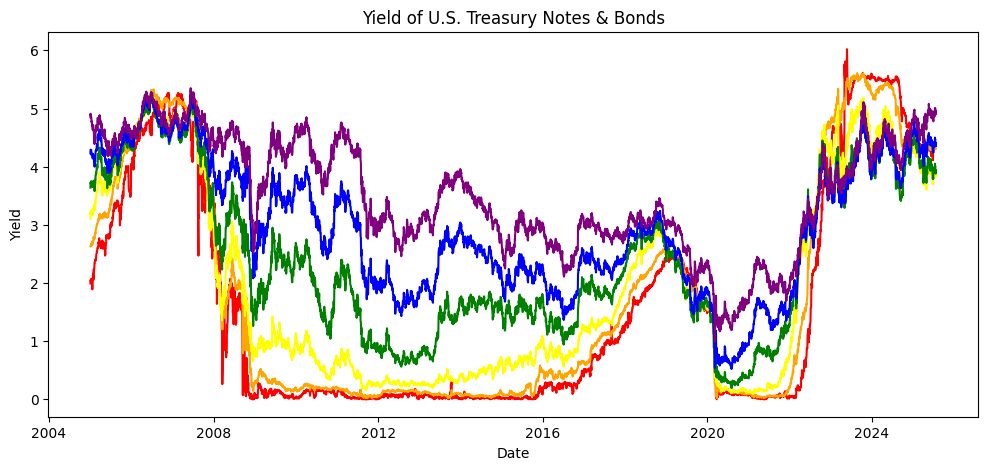

In [24]:
# Plot yields through time
plt.figure(figsize = (12,5))
plt.plot(df['1MO'], color='red')
plt.plot(df['6MO'], color='orange')
plt.plot(df['2YR'], color='yellow')
plt.plot(df['5YR'], color='green')
plt.plot(df['10YR'], color='blue')
plt.plot(df['30YR'], color='purple')
plt.xlabel('Date')
plt.ylabel('Yield')
plt.title('Yield of U.S. Treasury Notes & Bonds')
plt.show()

In [72]:
# Split into training 85%/ validation 10% / testing 5% 
n_train_end = int(len(df) * 0.85)
n_valid_end = int(len(df) * 0.95)
df_train = df.iloc[:n_train_end]
df_valid = df.iloc[n_train_end:n_valid_end]
df_test = df.iloc[n_valid_end:]

## PCA

In [73]:
# Do PCA on the training set
# Center the train data before PCA
yield_mean = df_train.mean()
df_train_c = df_train - yield_mean
df_valid_c = df_valid - yield_mean

# Get the first three principal components
pca = PCA(n_components=3)
pca.fit(df_train_c)
loadings = pca.components_

# Represent the original training data and validation data with a basis of the first three loadings
scores_train = df_train_c.to_numpy() @ loadings.T
scores_valid = df_valid_c.to_numpy() @ loadings.T


## LSTM

### Data preprocessing

In [74]:
# Preprocess score data
scaler = StandardScaler()
scaler.fit(scores_train)
scaled_scores_train = scaler.transform(scores_train)
scaled_scores_valid = scaler.transform(scores_valid)

# Prepare LSTM input
def create_LSTM_input(data, lag):
    X, Y = [], []
    for i in range(len(data) - lag):
        X.append(data[i:i+lag])
        Y.append(data[i+lag])
    X_tensor = torch.tensor(np.array(X), dtype=torch.float32)
    Y_tensor = torch.tensor(np.array(Y), dtype=torch.float32)
    return X_tensor, Y_tensor

lag = 10
Xtr, Ytr = create_LSTM_input(scaled_scores_train, lag)
Xv, Yv = create_LSTM_input(scaled_scores_valid, lag)

# Wrap the data in torch TensorDataset, DataLoader
dataset = TensorDataset(Xtr, Ytr)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

### Construct LSTM model

In [86]:
# Construct LSTM model

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, 
                            hidden_dim, 
                            num_layers,
                            dropout = dropout,
                            batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)               # out: (batch, seq_len, hidden_dim)
        out = out[:, -1, :]                 # use last output for forecasting
        out = self.linear(out)              # project to output dimension
        return out

model = LSTM(input_dim=3, hidden_dim=64, output_dim=3)

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 5

### Train

In [98]:
# Train LSTM model
model.train()
for epoch in range(epochs):
    for xb, yb in loader:
        pred = model(xb)
        loss = loss_func(pred, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 1 == 0:
        print(f"Epoch {epoch}: loss = {loss.item():.4f}")

Epoch 0: loss = 0.0112
Epoch 1: loss = 0.0183
Epoch 2: loss = 0.0317
Epoch 3: loss = 0.0118
Epoch 4: loss = 0.0162


In [99]:
# Validation
model.eval()
train_loss = loss_func(model(Xtr), Ytr)
val_loss = loss_func(model(Xv), Yv)
print(f'Train loss      : {train_loss}')
print(f'Validation loss : {val_loss}')

Train loss      : 0.015801627188920975
Validation loss : 0.08642256259918213


In [100]:
# Forecast
model.eval()
scores_fore = []

with torch.no_grad():
    x = torch.cat((Xv[-1:], torch.unsqueeze(Yv[-1:],0)), dim=1)[:,1:,:]
    for _ in range(len(df_test)):
        y = model(x)
        scaled_score = scaler.inverse_transform(y.numpy())
        scores_fore.append(scaled_score[0])
        x = torch.cat((x, torch.unsqueeze(y,0)), dim=1)[:,1:,:]
        
# Transfrom forecasted scores into yields
yield_fore = pd.DataFrame(pca.inverse_transform(np.array(scores_fore)), columns=df.columns, index=df_test.index) + yield_mean
yield_fore

,1MO,3MO,6MO,1YR,2YR,3YR,5YR,7YR,10YR,20YR,30YR
DATE,,,,,,,,,,,
2024-07-11,5.035825,5.037521,5.063897,4.846317,4.454095,4.248935,4.125923,4.132568,4.275535,4.547070,4.556276
2024-07-12,5.011208,5.013850,5.041639,4.826926,4.440463,4.239599,4.122715,4.132988,4.278187,4.552513,4.561544
2024-07-15,4.988378,4.993045,5.023601,4.813191,4.434491,4.238804,4.128125,4.141363,4.287550,4.563508,4.570963
2024-07-16,4.968793,4.976001,5.009927,4.804335,4.433818,4.243178,4.137680,4.152835,4.298771,4.575110,4.580279
2024-07-17,4.949543,4.959476,4.996957,4.796384,4.434095,4.248259,4.147104,4.163482,4.308386,4.584320,4.587060
...,...,...,...,...,...,...,...,...,...,...,...
2025-07-17,4.360180,4.506467,4.721183,4.751163,4.759500,4.785095,4.860937,4.909894,4.986584,5.219832,5.080619
2025-07-18,4.359027,4.505353,4.720120,4.750219,4.758768,4.784498,4.860492,4.909532,4.986244,5.219536,5.080337
2025-07-21,4.357883,4.504247,4.719065,4.749283,4.758042,4.783905,4.860051,4.909172,4.985906,5.219243,5.080058


In [101]:
# Calculate the MSE between the predicted yield and the actual yield
MSE = np.mean(np.sum((yield_fore.to_numpy() - df_test.to_numpy())**2, axis=1))
print(f'Mean Square Error : {MSE}')

Mean Square Error : 4.346301169054322


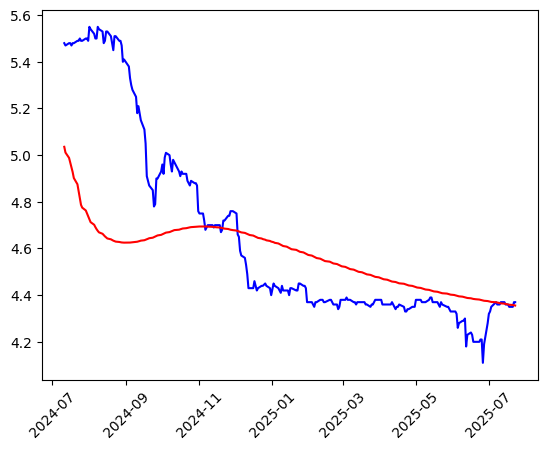

In [102]:
# Plot the froecasted and actual yield curve
plt.plot(df_test['1MO'], color='blue')
plt.plot(yield_fore['1MO'], color='red')
plt.tick_params('x', labelrotation=45)
plt.show()

## Conclusion

Compared with plain VAR, LSTM captures the nonlinear structure of the trend.